# Matching Market

This simple model consists of a buyer, a supplier, and a market. 

The buyer represents a group of customers whose willingness to pay for a single unit of the good is captured by a vector of prices _wta_. You can initiate the buyer with a set_quantity function which randomly assigns the willingness to pay according to your specifications. You may ask for these willingness to pay quantities with a _getbid_ function. 

The supplier is similar, but instead the supplier is willing to be paid to sell a unit of technology. The supplier for instance may have non-zero variable costs that make them unwilling to produce the good unless they receive a specified price. Similarly the supplier has a  get_ask function which returns a list of desired prices. 

The willingness to pay or sell are set randomly using uniform random distributions. The resultant lists of bids are effectively a demand curve. Likewise the list of asks is effectively a supply curve. A more complex determination of bids and asks is possible, for instance using time of year to vary the quantities being demanded. 

## New in version 18
- buyers should always consume, fixed by adding storage on which they can 'bank' the rational of the above is not the mimic strategic storage behavior but to address the reality that natural gas for household heating subtracted from the city-level distribution net is always delivered even if not directly paid for.
- added unproven reserves for paces scenario

## Microeconomic Foundations

The market assumes the presence of an auctioneer which will create a _book_, which seeks to match the bids and the asks as much as possible. If the auctioneer is neutral, then it is incentive compatible for the buyer and the supplier to truthfully announce their bids and asks. The auctioneer will find a single price which clears as much of the market as possible. Clearing the market means that as many willing swaps happens as possible. You may ask the market object at what price the market clears with the get_clearing_price function. You may also ask the market how many units were exchanged with the get_units_cleared function.

## Agent-Based Objects

The following section presents three objects which can be used to make an agent-based model of an efficient, two-sided market.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random as rnd
import pandas as pd
import numpy as np
import time
import datetime
import calendar
import json
import statistics

# fix what is missing with the datetime/time/calendar package
def add_months(sourcedate,months):
    month = sourcedate.month - 1 + months
    year = int(sourcedate.year + month / 12 )
    month = month % 12 + 1
    day = min(sourcedate.day,calendar.monthrange(year, month)[1])
    return datetime.date(year,month,day)

# measure how long it takes to run the script
startit = time.time()
dtstartit = datetime.datetime.now()

## classes buyers and sellers
Below we are constructing the buyers and sellers in classes.

In [2]:
class Seller():
    def __init__(self, name):
        self.name = name
        self.wta = []
        self.step = 0
        self.prod = 2000
        self.lb_price = 10
        self.lb_multiplier = 0
        self.ub_price = 20
        self.ub_multiplier = 0
        self.init_reserve = 500000
        self.reserve = 500000
        self.init_unproven_reserve = 0
        self.unproven_reserve = 0
        #multiple market idea, also 'go away from market'
        self.subscr_market = {}
        self.last_price = 15
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.storage = 0
        self.q_to_market = 0
        self.ratio_sold = 0
        self.ratio_sold_hist = []

    # the supplier has n quantities that they can sell
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = self.prod
        l = self.lb_price + self.lb_multiplier
        u = self.ub_price + self.ub_multiplier
        wta = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wta.append(p)
        if len(wta) < self.reserve:
            self.wta = wta
        else:
            self.wta = wta[0:(self.reserve-1)]
            self.prod = self.reserve
        if len(self.wta) > 0:
            self.wta = self.wta #sorted(self.wta, reverse=False)
        self.q_to_market = len(self.wta)
        
        
    def get_name(self):
        return self.name

    def get_asks(self):
        return self.wta

    def extract(self, cur_extraction):
        if self.reserve > 0:
            self.reserve = self.reserve - cur_extraction
        else:
            self.prod = 0

    # production costs rise a 100% 
    def update_price(self):
        depletion = (self.init_reserve - self.reserve) / self.init_reserve
        self.ub_multiplier = int(self.ub_price * depletion)
        self.lb_multiplier = int(self.lb_price * depletion)
        
    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wta) - len(not_cleared))
        self.wta = not_cleared

    def get_price(self, price):
        self.last_price = price
        
    def update_production(self):
        if (self.step/12).is_integer():
            if self.prod > 0 and self.q_to_market > 0:
                rp_ratio = self.reserve / self.prod
                self.ratio_sold = self.count / self.q_to_market
                self.ratio_sold_hist.append(self.ratio_sold)
                yearly_average = statistics.mean(self.ratio_sold_hist[-12:])
                if (rp_ratio > 15) and (yearly_average > .9):
                    print("%s evaluate production" % self.name)
                    self.prod = int(self.prod * 1.1)
                if (self.unproven_reserve > 0) and (self.cur_scenario == 'PACES'):
                    self.reserve = self.reserve + int(0.1 * self.init_unproven_reserve)
                    self.unproven_reserve = self.unproven_reserve - int(0.1 * self.init_unproven_reserve)
                    
    def evaluate_timestep(self):
        self.update_production()

    # record every step into an dictionary, nog pythonic look into (vars)
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__

        
class Buyer():
    def __init__(self, name):
        self.name = name
        self.type = 0
        self.rof = 0
        self.wtp = []
        self.step = 0
        self.offset= 0
        self.base_demand = 0
        self.max_demand = 0
        self.lb_price = 10
        self.ub_price = 20
        self.last_price = 15
        self.subscr_market = {}
        self.state_hist = {}
        self.cur_scenario = ''
        self.count = 0
        self.real_demand = 0
        self.storage_cap = 1
        self.storage = 0
        self.storage_q = 0

    # the supplier has n quantities that they can buy
    # they may be willing to sell this quantity anywhere from a lower price of l
    # to a higher price of u
    def set_quantity(self):
        self.count = 0
        self.update_price()
        n = int(self.consumption(self.step))
        l = self.lb_price
        u = self.ub_price
        wtp = []
        for i in range(n):
            p = rnd.uniform(l, u)
            wtp.append(p)
        self.wtp = wtp #sorted(wtp, reverse=True)
        
    # gets a little to obvious
    def get_name(self):
        return self.name
    
    # return list of willingness to pay
    def get_bids(self):
        return self.wtp
    
    def consumption(self, x):
        # make it initialise to seller
        b = self.base_demand
        m = self.max_demand
        y = b + m * (.5 * (1 + np.cos(((x+self.offset)/6)*np.pi)))
        self.real_demand = y
        s = self.storage_manager()
        return(y+s)
    
    def update_price(self):
        # adjust Q
        if self.type == 1: #home
            if (self.step/12).is_integer():
                self.base_demand = home_savings[self.cur_scenario] * self.base_demand
                self.max_demand = home_savings[self.cur_scenario] * self.max_demand
        if self.type == 2: # elec for eu + us
            if (self.step/12).is_integer():
                cur_elec_df = elec_space['RELATIVE'][self.cur_scenario]
                period_now = add_months(period_null, self.step)
                index_year = int(period_now.strftime('%Y'))
                #change_in_demand = cur_elec_df[index_year]
                self.base_demand = self.base_demand * cur_elec_df[index_year]
                self.max_demand = self.max_demand * cur_elec_df[index_year]
        if self.type == 3: #indu
            if (self.step/12).is_integer():
                if (self.rof == 0) and (self.cur_scenario == 'PACES'):
                    #cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    #growth = cur_df[index_year]
                    growth = np.arctan((index_year-2013)/10)/(.5*np.pi)*.05+0.03
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                else:
                    cur_df = economic_growth['ECONOMIC GROWTH'][self.cur_scenario]
                    period_now = add_months(period_null, self.step)
                    index_year = int(period_now.strftime('%Y'))
                    growth = cur_df[index_year]
                    self.base_demand = (1 + growth) * self.base_demand
                    self.max_demand = (1 + growth) * self.max_demand
                    
        ## adjust P now to get_price, but adress later
        ## moved to get_price, rename update_price function (?)
        #self.lb_price = self.last_price * .75
        #self.ub_price= self.last_price * 1.25

    def return_not_cleared(self, not_cleared):
        self.count = self.count + (len(self.wtp)-len(not_cleared))
        self.wtp = not_cleared

    def get_price(self, price):
        self.last_price = price
        if self.last_price > 100:
            self.last_price = 100
        self.lb_price = self.last_price * .75
        self.ub_price= self.last_price * 1.25
    
    # writes complete state to a dictionary, see if usefull
    def book_keeping(self):
        self.state_hist[self.step] = self.__dict__
        
    # there has to be some accountability for uncleared bids of the buyers
    def evaluate_timestep(self):
        if self.type==1:
            not_cleared = len(self.wtp)
            #total_demand = self.real_demand + self.storage_q
            storage_delta = self.storage_q - not_cleared
            self.storage = self.storage + storage_delta
            print(self.name, storage_delta)

    def storage_manager(self):
        # check if buyer is household buyer
        if self.type==1:
            if self.storage < 0:
                self.storage_q = -self.storage
            else:
                self.storage_q = 0
            return(self.storage_q)
        else:
            return(0)


## Construct the market
For the market two classes are made. The market itself, which controls the buyers and the sellers, and the book. The market has a book where the results of the clearing procedure are stored.

In [3]:
# the book is an object of the market used for the clearing procedure
class Book():
    def __init__(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

    def set_asks(self,seller_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for seller in seller_list:
            seller_name = seller.get_name()
            seller_price = seller.get_asks()
            #seller_df = [['seller' for i in seller_price],
            #              [seller_name for i in seller_price],
            #              seller_price,
            #              ['in process' for i in seller_price]]
            #seller_df = np.array(seller_df).T
            ar_role = np.full((1,len(seller_price)),'seller')
            ar_name = np.full((1,len(seller_price)),seller_name)
            ar_cleared = np.full((1,len(seller_price)),'in process')
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,seller_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            #temp_ledger = pd.DataFrame(seller_df, columns= ["role","name","price","cleared"])
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)

    def set_bids(self,buyer_list):
        # ask each seller their name
        # ask each seller their willingness
        # for each willingness append the data frame
        for buyer in buyer_list:
            buyer_name = buyer.get_name()
            buyer_price = buyer.get_bids()
            #buyer_df = []
            #for i in buyer_price:
            #    buyer_df.append(['buyer',buyer_name,i,'in process'])
            ar_role = np.full((1,len(buyer_price)),'buyer')
            ar_name = np.full((1,len(buyer_price)),buyer_name)
            ar_cleared = np.full((1,len(buyer_price)),'in process')
            temp_ledger = pd.DataFrame([*ar_role,*ar_name,buyer_price,*ar_cleared]).T
            temp_ledger.columns= ["role","name","price","cleared"]
            #temp_ledger = pd.DataFrame(buyer_df, columns= ["role","name","price","cleared"])
            self.ledger = self.ledger.append(temp_ledger, ignore_index=True)
            
    def update_ledger(self,ledger):
        self.ledger = ledger
        
    def get_ledger(self):
        return self.ledger
    
    def clean_ledger(self):
        self.ledger = pd.DataFrame(columns = ("role","name","price","cleared"))

class Market():
    def __init__(self, name):
        self.name= name
        self.count = 0
        self.last_price = ''
        self.book = Book()
        self.b = []
        self.s = []
        self.buyer_list = []
        self.seller_list = []
        self.buyer_dict = {}
        self.seller_dict = {}
        self.ledger = ''

    # move to observer
    # not called
    def update_seller(self):
        for i in self.seller_dict:
            self.seller_dict[i].step += 1
            self.seller_dict[i].set_quantity()
    
    # not called
    def update_buyer(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].step += 1
            self.buyer_dict[i].set_quantity()
            
    def book_keeping_all(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].book_keeping()
        for i in self.seller_dict:
            self.seller_dict[i].book_keeping()
    
    def add_buyer(self,buyer):
        if buyer.subscr_market[self.name] == 1:
            self.buyer_list.append(buyer)
        
    def add_seller(self,seller):
        if seller.subscr_market[self.name] == 1:       
            self.seller_list.append(seller)
        
    def set_book(self):
        self.book.set_bids(self.buyer_list)
        self.book.set_asks(self.seller_list)
    
    #def get_ledger(self):
    #    self.ledger = self.book.get_ledger()
    #    return self.ledger
    
    def get_bids(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows= ledger.loc[ledger['role'] == 'buyer']
        # this is a series
        prices=rows['price']
        # this is a list
        bids = prices.tolist()
        return bids
    
    def get_asks(self):
        # this is a data frame
        ledger = self.book.get_ledger()
        rows = ledger.loc[ledger['role'] == 'seller']
        # this is a series
        prices=rows['price']
        # this is a list
        asks = prices.tolist()
        return asks
    
    # return the price at which the market clears
    # this fails because there are more buyers then sellers
    
    def get_clearing_price(self):
        # buyer makes a bid starting with the buyer which wants it most
        b = self.get_bids()
        s = self.get_asks()
        # highest to lowest
        self.b=sorted(b, reverse=True)
        # lowest to highest
        self.s=sorted(s, reverse=False)
        
        # find out whether there are more buyers or sellers
        # then drop the excess buyers or sellers; they won't compete
        n = len(b)
        m = len(s)
        
        # there are more sellers than buyers
        # drop off the highest priced sellers 
        if (m > n):
            s = s[0:n]
            matcher = n
        # There are more buyers than sellers
        # drop off the lowest bidding buyers 
        else:
            b = b[0:m]
            matcher = m
        
        # It's possible that not all items sold actually clear the market here
        # Produces an error when one of the two lists are empty
        # something like 'can't compare string and float'
        count = 0
        for i in range(matcher):
            if (self.b[i] > self.s[i]):
                count +=1
                self.last_price = self.b[i]
        
        # copy count to market object
        self.count = count
        return self.last_price
    
    # TODO: Annotate the ledger
    # this procedure takes up 80% of processing time
    def annotate_ledger(self,clearing_price):
        ledger = self.book.get_ledger()
        for index, row in ledger.iterrows():
            if (row['role'] == 'seller'):
                if (row['price'] < clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'
            else:
                if (row['price'] > clearing_price):
                    ledger.loc[index,'cleared'] = 'True'
                else:
                    ledger.loc[index,'cleared'] = 'False'  
                    
        self.book.update_ledger(ledger)
    
    def get_units_cleared(self):
        return self.count
    
    def clean_ledger(self):
        self.ledger = ''
        self.book.clean_ledger()

    def run_it(self):
        self.pre_clearing_operation()
        self.clearing_operation()
        self.after_clearing_operation()
        
        # pre clearing empty out the last run and start
        # clean ledger is kind of sloppy, rewrite functions to overide the ledger
    def pre_clearing_operation(self):
        self.clean_ledger()
        
    def clearing_operation(self):
        self.set_book()
        clearing_price = self.get_clearing_price()
        print(self.name, clearing_price)
        #start_clearing = datetime.datetime.now()
        self.annotate_ledger(clearing_price)
        #print(datetime.datetime.now() - start_clearing)
        
    def after_clearing_operation(self):
        for agent in self.seller_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                              (self.book.ledger['name'] == name)])
            agent.extract(cur_extract)
            agent.get_price(self.last_price)
            if cur_extract >0:
                agent_asks = agent.get_asks()
                agent_asks = sorted(agent_asks, reverse=False)
                not_cleared = agent_asks[cur_extract:len(agent_asks)]
                agent.return_not_cleared(not_cleared)

        for agent in self.buyer_list:
            name = agent.name
            cur_extract = len(self.book.ledger[(self.book.ledger['cleared'] == 'True') &
                              (self.book.ledger['name'] == name)])
            agent.get_price(self.last_price)
            if cur_extract >0:
                agent_bids = agent.get_bids()
                agent_bids = sorted(agent_bids, reverse=True)
                not_cleared = agent_bids[cur_extract:len(agent_bids)]
                agent.return_not_cleared(not_cleared)
            #print(name,cur_extract)

        # cleaning up the books
        self.book_keeping_all()


## Observer
The observer holds the clock and collects data. In this setup it tells the market another tick has past and it is time to act. The market will instruct the other agents. The observer initializes the model, thereby making real objects out of the classes defined above.

In [4]:
class Observer():
    def __init__(self, init_buyer, init_seller, timesteps, scenario):
        self.init_buyer = init_buyer
        self.init_seller = init_seller
        self.init_market = init_market
        self.maxrun = timesteps
        self.cur_scenario = scenario
        self.buyer_dict = {}
        self.seller_dict = {}
        self.market_dict = {}
        self.timetick = 0
        self.gas_market = ''
        self.market_hist = []
        self.seller_hist = []
        self.buyer_hist = []
        self.all_data = {}

    def set_buyer(self, buyer_info):
        for name in buyer_info:
            self.buyer_dict[name] = Buyer('%s' % name)
            self.buyer_dict[name].base_demand = buyer_info[name]['offset']
            self.buyer_dict[name].base_demand = buyer_info[name]['b']
            self.buyer_dict[name].max_demand = buyer_info[name]['m']
            self.buyer_dict[name].lb_price = buyer_info[name]['lb_price']
            self.buyer_dict[name].ub_price = buyer_info[name]['ub_price']
            self.buyer_dict[name].type = buyer_info[name]['type']
            self.buyer_dict[name].rof = buyer_info[name]['rof']
            self.buyer_dict[name].cur_scenario = self.cur_scenario
            self.buyer_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in buyer_info[name]['market']:
                self.buyer_dict[name].subscr_market[market] = 1

    def set_seller(self, seller_info):
        for name in seller_info:
            self.seller_dict[name] = Seller('%s' % name)
            self.seller_dict[name].prod = seller_info[name]['prod']
            self.seller_dict[name].lb_price = seller_info[name]['lb_price']
            self.seller_dict[name].ub_price = seller_info[name]['ub_price']
            self.seller_dict[name].reserve = seller_info[name]['reserve']
            self.seller_dict[name].init_reserve = seller_info[name]['reserve']
            self.seller_dict[name].unproven_reserve = seller_info[name]['UP_reserve']
            self.seller_dict[name].init_unproven_reserve = seller_info[name]['UP_reserve']
            #self.seller_dict[name].rof = seller_info[name]['rof']
            self.seller_dict[name].cur_scenario = self.cur_scenario
            self.seller_dict[name].subscr_market = dict.fromkeys(init_market,0)
            for market in seller_info[name]['market']:
                self.seller_dict[name].subscr_market[market] = 1
    
    def set_market(self, market_info):
        for name in market_info:
            self.market_dict[name] = Market('%s' % name)
        #add suplliers and buyers to this market
            for supplier in self.seller_dict.values():
                self.market_dict[name].add_seller(supplier)
            for buyer in self.buyer_dict.values():
                self.market_dict[name].add_buyer(buyer)
            self.market_dict[name].seller_dict = self.seller_dict
            self.market_dict[name].buyer_dict = self.buyer_dict
    
    def update_buyer(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].step += 1
            self.buyer_dict[i].set_quantity()
    
    def update_seller(self):
        for i in self.seller_dict:
            self.seller_dict[i].step += 1
            self.seller_dict[i].set_quantity()

    def evaluate_timestep(self):
        for i in self.buyer_dict:
            self.buyer_dict[i].evaluate_timestep()
        for i in self.seller_dict:
            self.seller_dict[i].evaluate_timestep()

    def get_reserve(self):
        reserve = []
        for name in self.seller_dict:
            reserve.append(self.seller_dict[name].reserve)
        return reserve            

    def get_data(self):
        for name in self.seller_dict:
            self.all_data[name] = self.seller_dict[name].state_hist
        for name in self.buyer_dict:
            self.all_data[name] = self.buyer_dict[name].state_hist

    def run_it(self):
        # Timing
        # time initialising
        startit_init = time.time()
        
        #initialise, setting up all the agents (firstrun not really needed anymore, since outside the loop)
        first_run = True
        if first_run:
            self.set_buyer(self.init_buyer)
            self.set_seller(self.init_seller)
            self.set_market(self.init_market)
            first_run=False
            
        # time init stop
        stopit_init = time.time() - startit_init
        print('%s : init' % stopit_init)
        
        # recording everything in dataframes, more dependable than lists?
        reserve_df = pd.DataFrame(data=None, columns=[i for i in self.seller_dict])
        market_df = pd.DataFrame(data=None, columns = [i for i in self.market_dict])

        for period in range(self.maxrun):
            # time the period
            startit_period = time.time()

            self.timetick += 1
            print('#######################################')
            period_now = add_months(period_null, self.timetick-1)
            print(period_now.strftime('%Y-%b'), self.cur_scenario)
            
            # update the buyers and sellers (timetick+ set Q)
            self.update_buyer()
            self.update_seller()
            
            # real action on the market
            for market in self.market_dict:
                if market != 'lng':
                    self.market_dict[market].run_it()
            self.market_dict['lng'].run_it()

            #tell buyers timetick has past
            self.evaluate_timestep()
                

            # data collection
            for name in self.market_dict:
                p_clearing = self.market_dict[name].last_price
                q_sold = self.market_dict[name].count
                self.market_hist.append([period_now.strftime('%Y-%b'), p_clearing, q_sold, name])
            
            for name in self.seller_dict:
                reserve = self.seller_dict[name].reserve
                produced = self.seller_dict[name].count
                self.seller_hist.append([period_now.strftime('%Y-%b'), reserve, produced, name])
                
            for name in self.buyer_dict:
                storage = self.buyer_dict[name].storage
                consumed = self.buyer_dict[name].count
                self.buyer_hist.append([period_now.strftime('%Y-%b'), storage, consumed, name])
                
            # recording the step_info
            # since this operation can take quite a while, print after every operation
            period_time = time.time() - startit_period
            print('%.2f : seconds to clear period' % period_time)
            #self.hist_book.append([period_now.strftime('%Y-%b'), p_clearing, q_sold])


## Example Market

In the following code example we use the buyer and supplier objects to create a market. At the market a single price is announced which causes as many units of goods to be swapped as possible. The buyers and sellers stop trading when it is no longer in their own interest to continue. 

In [5]:
# import scenarios
inputfile = 'economic growth scenarios.xlsx'
# economic growth percentages
economic_growth = pd.read_excel(inputfile, sheet='ec_growth', index_col=0, header=[0,1])

## demand for electricity import scenarios spaced by excel
#elec_space = pd.read_excel(inputfile, sheetname='elec_space', skiprows=1, index_col=0, header=0)

# demand for electricity import scenarios spaced by excel
elec_space = pd.read_excel(inputfile, sheetname='elec_space', index_col=0, header=[0,1])

# gasdemand home (percentage increases)
home_savings = {'PACES': 1.01, 'TIDES': .99, 'CIRCLES': .97}

# multilevel ecgrowth
economic_growth2 = pd.read_excel(inputfile, sheet='ec_growth', index_col=0, header=[0,1])

#economic_growth2['ECONOMIC GROWTH']

In [6]:
# reading excel initialization data back
read_file = 'init_buyers_sellers_lng.xlsx'
df_buyer = pd.read_excel(read_file,orient='index',sheetname='buyers')
df_seller = pd.read_excel(read_file,orient='index',sheetname='sellers')
df_buyer['market'] = [eval(i) for i in df_buyer['market'].values]
df_seller['market'] = [eval(i) for i in df_seller['market'].values]
init_buyer = df_buyer.to_dict('index')
init_seller = df_seller.to_dict('index')

#init_market = {'eu', 'us','as'}, construct markets by unique values
market = []
for i in init_seller:
    for x in init_seller[i]['market']: market.append(x)
for i in init_buyer:
    for x in init_buyer[i]['market']: market.append(x)
market = list(set(market))
init_market = market

# set the starting time
period_null= datetime.date(2013,1,1)

In [7]:
# writing initialisation data to excel (only use when not used for initialization)

#writer = pd.ExcelWriter('init_buyers_sellers.xlsx')
#df_buyers = pd.DataFrame.from_dict(init_buyer, 'index')
#df_buyers.to_excel(writer, sheet_name='buyers')
#df_sellers = pd.DataFrame.from_dict(init_seller, 'index')
#df_sellers.to_excel(writer, sheet_name='sellers')

#print(init_buyer['sa'])
print(init_market)
#init_buyer['home_us']['offset']
print('\nsellers')
#for i in obser1.market_dict: print( i, [x.name for x in obser1.market_dict[i].seller_list])

print('\nbuyers')
#for i in obser1.market_dict: print( i, [x.name for x in obser1.market_dict[i].buyer_list])
#init_seller

['af', 'lng', 'sa', 'eu', 'as', 'ir', 'au', 'cn', 'na', 'ru', 'me']

sellers

buyers


## run the model
To run the model we create the observer. The observer creates all the other objects and runs the model.

In [8]:
# create observer and run the model
# first data about buyers then sellers and then model ticks
years = 10
# timestep = 12
run_market = {}
run_seller = {}
run_buyer = {}
for i in ['PACES', 'CIRCLES', 'TIDES']:
    print('\n%s' %i)
    obser1 = Observer(init_buyer, init_seller, years*12, i)
    obser1.run_it()
    #get the info from the observer
    run_market[i] = obser1.market_hist
    run_seller[i] = obser1.seller_hist
    run_buyer[i] = obser1.buyer_hist
    #run_data[i] = obser1.all_data


PACES
0.010117292404174805 : init
#######################################
2013-Jan PACES
af 14.865121808582622
au 13.281269885253984
sa 13.911434634517548
ir 16.299641280349263
na 15.499226422961724
ru 15.026175769963228
me 16.137879420166392
eu 15.928425071215788
as 16.13487832422286
cn 16.630515509220523
lng 15.866953507900146
home_eu -270
home_na -180
2.55 : seconds to clear period
#######################################
2013-Feb PACES
af 15.737086330431797
au 15.39883205415963
sa 14.35436788712277
ir 15.331592118017303
na 16.003508002505544
ru 15.523210831043622
me 16.618775600442564
eu 16.939391880186136
as 16.634179926838048
cn 16.5821444133865
lng 16.47975407762785
home_eu -82
home_na -63
2.57 : seconds to clear period
#######################################
2013-Mar PACES
af 15.495937895349032
au 14.119766962447274
sa 13.707325918394606
ir 16.073316973167174
na 16.12056889951941
ru 15.289599122481935
me 16.105809664466623
eu 17.14513047528547
as 16.661707004109207
cn 16.650974

ir 16.896929033894583
na 14.368841308489687
ru 15.709269325656694
me 16.86419735934512
eu 17.740869199979755
as 17.15816340946711
cn 16.914993486926292
lng 17.326488334575455
home_eu -66
home_na -28
Nigeria evaluate production
Denmark evaluate production
Other Europe Eurasia evaluate production
North Africa evaluate production
Romania evaluate production
2.74 : seconds to clear period
#######################################
2015-Jan PACES
af 14.946905956790879
au 13.127435975420918
sa 13.014987589795155
ir 17.13090743469012
na 15.181290453844596
ru 16.46129248816378
me 17.345312890685182
eu 18.483347788012914
as 18.161703099643685
cn 17.711257733905082
lng 17.908643130139076
home_eu -7
home_na 3
2.64 : seconds to clear period
#######################################
2015-Feb PACES
af 16.275778521870492
au 13.45573751020489
sa 13.597559250022302
ir 17.305791077215854
na 15.034345341704446
ru 16.59474618847646
me 17.46981595255037
eu 19.007887396947275
as 17.98065389709815
cn 18.100968455

cn 14.17441408217187
lng 15.543464208810414
home_eu -108
home_na -1
2.60 : seconds to clear period
#######################################
2016-Nov PACES
af 13.33396578752873
au 11.664684853928671
sa 12.236768455346283
ir 16.41134733617818
na 12.09701713697164
ru 15.63752430410348
me 16.19166207022943
eu 16.79553244783684
as 16.769129664066526
cn 15.260842253539085
lng 16.442352656876597
home_eu -105
home_na -17
2.81 : seconds to clear period
#######################################
2016-Dec PACES
af 15.565035804885039
au 12.845618121743883
sa 13.280316131114162
ir 17.170489705999216
na 13.235118855536257
ru 16.315488552136024
me 17.356219885092088
eu 17.699589629860043
as 17.503728294011864
cn 16.544285882176226
lng 17.345984317617678
home_eu -91
home_na -29
North America evaluate production
Denmark evaluate production
South America evaluate production
Other Europe Eurasia evaluate production
North Africa evaluate production
Romania evaluate production
Australia evaluate production
Chi

as 14.650046359751627
cn 11.19350898832693
lng 14.030084638579753
home_eu -68
home_na 0
2.13 : seconds to clear period
#######################################
2018-Sep PACES
af 12.62254618829076
au 10.611669085771664
sa 10.540381561409594
ir 14.43006904247688
na 10.533233038773544
ru 14.272426806448683
me 14.606486749875096
eu 14.565568582832666
as 15.029109940230098
cn 12.78509499016411
lng 14.517323809707108
home_eu -93
home_na 0
2.36 : seconds to clear period
#######################################
2018-Oct PACES
af 14.598011185108433
au 10.935321746956687
sa 10.922395691105391
ir 15.308040801063648
na 10.888431207543515
ru 14.796134881706097
me 15.42848478106185
eu 15.500627251110483
as 15.8772003736564
cn 13.672879228769018
lng 15.353064603636204
home_eu -141
home_na 0
2.61 : seconds to clear period
#######################################
2018-Nov PACES
af 14.54859726234179
au 12.039640126823356
sa 11.65692017748309
ir 16.09512883760884
na 11.518888042521766
ru 15.137118752913521


home_eu 112
home_na -1
2.06 : seconds to clear period
#######################################
2020-Jun PACES
af 12.926726054279186
au 11.798383849385619
sa 11.752051326270255
ir 14.798376603344524
na 11.703449354620938
ru 14.59260281846673
me 14.224825988040193
eu 14.711020556709054
as 14.829992526537588
cn 11.705937886942213
lng 14.460981014336513
home_eu 60
home_na 1
1.98 : seconds to clear period
#######################################
2020-Jul PACES
af 12.089029999051332
au 10.926265201974347
sa 10.972235797546249
ir 14.791717773645377
na 10.854759105060564
ru 14.093260673453191
me 14.056636957817812
eu 13.550133730999384
as 14.378331271752824
cn 10.892696871479949
lng 13.909462664652214
home_eu -2
home_na -1
2.08 : seconds to clear period
#######################################
2020-Aug PACES
af 12.024266442619014
au 10.62380998596285
sa 10.612068798008119
ir 14.37080013341554
na 10.478335063574281
ru 14.262998876652155
me 14.088517400101665
eu 13.604426296328038
as 14.88660223320

lng 18.343336732200292
home_eu 29
home_na 0
2.94 : seconds to clear period
#######################################
2022-Mar PACES
af 15.56060372696812
au 13.812848334169306
sa 13.778259110962388
ir 17.993987201594706
na 13.795592934851722
ru 16.756020723025216
me 18.135499957261747
eu 18.385921561011962
as 18.187962389826126
cn 15.352058647937453
lng 17.94292619341378
home_eu 141
home_na 0
2.69 : seconds to clear period
#######################################
2022-Apr PACES
af 14.740148612969218
au 13.6677502085186
sa 13.504013888329538
ir 17.191505887270026
na 13.465596509286923
ru 16.03841754399501
me 16.021624784706862
eu 17.153579119538946
as 17.19232099565928
cn 13.461418143247373
lng 16.813415137096953
home_eu 182
home_na 0
2.38 : seconds to clear period
#######################################
2022-May PACES
af 13.208021922190689
au 12.67804453323127
sa 12.877321856973161
ir 15.8919484424948
na 12.62167218059012
ru 15.202169955334577
me 14.920002729381165
eu 15.713409113883564
as

home_eu -36
home_na -54
Denmark evaluate production
Poland evaluate production
Azerbaijan evaluate production
North Africa evaluate production
2.81 : seconds to clear period
#######################################
2014-Jan CIRCLES
af 15.853890419490519
au 15.491174507498473
sa 15.517714344804116
ir 17.674181177870764
na 17.85864426944576
ru 16.603478742200483
me 18.075312081569955
eu 18.811232935356724
as 18.3714528026419
cn 18.673700224378308
lng 18.240653926429168
home_eu 33
home_na 22
2.70 : seconds to clear period
#######################################
2014-Feb CIRCLES
af 16.700553658141757
au 15.449510512106945
sa 14.675834011028282
ir 17.373844092969257
na 18.197823079340715
ru 16.344631525957233
me 17.810940766664782
eu 19.044085873720952
as 17.940978067404703
cn 18.389982957494915
lng 18.209581489771224
home_eu 64
home_na 42
2.55 : seconds to clear period
#######################################
2014-Mar CIRCLES
af 16.195242682402885
au 15.146439284433875
sa 14.638554552302685


cn 17.400562744179545
lng 17.055438404047216
home_eu -113
home_na -108
2.73 : seconds to clear period
#######################################
2015-Dec CIRCLES
af 16.36775572302014
au 14.977134126168663
sa 14.749879707113353
ir 16.874692691918668
na 17.942202132413136
ru 16.359012771605226
me 17.43984912167515
eu 18.487772217881417
as 17.74059585705609
cn 18.28641581838733
lng 17.862756964427128
home_eu -33
home_na -55
Ukraine evaluate production
Poland evaluate production
2.86 : seconds to clear period
#######################################
2016-Jan CIRCLES
af 16.815270881840863
au 15.642756751644622
sa 15.181136012542467
ir 17.352812593281474
na 18.503837282965094
ru 16.73600597401731
me 18.34507001810147
eu 19.109129915830753
as 18.326777910196192
cn 19.202612385296618
lng 18.484717842816274
home_eu 8
home_na -28
2.77 : seconds to clear period
#######################################
2016-Feb CIRCLES
af 16.699578709219416
au 15.382136674236435
sa 14.90865669030955
ir 17.2212403761475

eu 17.548983460668076
as 17.33775648245991
cn 17.65933644592605
lng 17.123396288816927
home_eu -86
home_na -99
2.56 : seconds to clear period
#######################################
2017-Nov CIRCLES
af 16.873523353756436
au 15.20768263044873
sa 14.923641259836508
ir 16.779509318941386
na 18.303339235781404
ru 16.67011568748026
me 17.897531531093605
eu 18.529670926995124
as 17.950654385001354
cn 18.19026198723662
lng 18.038473971068576
home_eu -97
home_na -99
2.73 : seconds to clear period
#######################################
2017-Dec CIRCLES
af 16.205593033628357
au 14.547211288680382
sa 15.417373571933176
ir 17.61677913828505
na 19.08011931549449
ru 17.396384583567453
me 18.167856070613528
eu 19.521112144505416
as 18.966034462282785
cn 19.360940936921736
lng 18.88761760794919
home_eu -36
home_na -36
Poland evaluate production
2.83 : seconds to clear period
#######################################
2018-Jan CIRCLES
af 16.489474334213735
au 15.636466716997568
sa 16.210637013254065
ir 1

ir 16.748336400399662
na 17.888764755093526
ru 16.348357541561956
me 17.33219188580835
eu 18.023732572536453
as 17.683686703280298
cn 17.869816274188405
lng 17.547602841680465
home_eu -90
home_na -78
2.56 : seconds to clear period
#######################################
2019-Nov CIRCLES
af 17.07724758006838
au 15.596914790165918
sa 15.715286319839265
ir 17.317804389766845
na 18.697879976803197
ru 16.875351097026396
me 18.430118586979145
eu 18.974150338508792
as 18.551800068786065
cn 19.166101370101213
lng 18.484857543656087
home_eu -55
home_na -65
2.75 : seconds to clear period
#######################################
2019-Dec CIRCLES
af 17.6509564519645
au 16.674358876266652
sa 16.23647559875735
ir 18.484768737251073
na 19.778344233355103
ru 17.827822683644296
me 19.159983087683113
eu 19.880023011101052
as 19.701884543795508
cn 19.904796557281138
lng 19.472702899495534
home_eu -39
home_na -73
2.86 : seconds to clear period
#######################################
2020-Jan CIRCLES
af 17.

as 17.988585890953885
cn 18.611867813716266
lng 17.65034536553776
home_eu -81
home_na -69
2.38 : seconds to clear period
#######################################
2021-Oct CIRCLES
af 17.56363726605861
au 16.291129976966307
sa 16.005626146065346
ir 17.26591000776166
na 18.962843168634677
ru 17.28319849260029
me 18.331583082491825
eu 18.840193336334657
as 19.264089793675662
cn 19.234006250079602
lng 18.67307451199862
home_eu -88
home_na -77
2.63 : seconds to clear period
#######################################
2021-Nov CIRCLES
af 17.5688802835602
au 16.949224713791892
sa 16.478325683562034
ir 18.11324103535038
na 20.021084092118187
ru 18.04352553234542
me 19.100800571933462
eu 19.847691876093524
as 19.873200749812145
cn 20.38937378106813
lng 19.587470020890077
home_eu -83
home_na -64
2.80 : seconds to clear period
#######################################
2021-Dec CIRCLES
af 18.835097698396623
au 17.556740208567767
sa 16.755927391741448
ir 19.001031338972254
na 21.008509648835226
ru 19.03429

me 14.362318415881184
eu 15.118291447134158
as 14.936597760021964
cn 15.895623714851503
lng 14.62575434574168
home_eu -39
home_na -36
2.06 : seconds to clear period
#######################################
2013-Sep TIDES
af 14.101648070570468
au 14.062824659480267
sa 13.769181465486234
ir 14.880306946112244
na 14.495460669445741
ru 14.293366925188616
me 14.746306300203937
eu 15.82948920006191
as 15.053498422774474
cn 15.441424095717576
lng 15.276383106488442
home_eu -103
home_na -74
2.28 : seconds to clear period
#######################################
2013-Oct TIDES
af 15.002150948452208
au 14.22428397917929
sa 13.56515984052931
ir 15.511732622231824
na 15.71066554543271
ru 14.990527165521602
me 16.039372696469
eu 16.48333312852929
as 15.817216930140763
cn 16.27130045465055
lng 15.961841062113862
home_eu -94
home_na -72
2.56 : seconds to clear period
#######################################
2013-Nov TIDES
af 15.798693392056332
au 14.359929735389697
sa 14.49155519660751
ir 16.34080920872

eu 15.83239992579181
as 14.980710811627372
cn 15.936627410027066
lng 15.112020939579164
home_eu -46
home_na -8
1.94 : seconds to clear period
#######################################
2015-Aug TIDES
af 14.149298009169158
au 13.221853109907627
sa 12.931748472358123
ir 14.194864048910524
na 15.453155153761555
ru 14.291817505360509
me 15.456333230483116
eu 15.658420029701137
as 15.305389954502264
cn 15.708340668202645
lng 15.205233272568712
home_eu -46
home_na -32
2.11 : seconds to clear period
#######################################
2015-Sep TIDES
af 14.452886670057524
au 13.341133847304228
sa 13.526249003268916
ir 15.30255957548099
na 15.887565567039626
ru 14.87230110146741
me 15.537997456104845
eu 16.440547455759877
as 15.956938556233364
cn 15.72064164237262
lng 15.798498469214977
home_eu -79
home_na -84
2.38 : seconds to clear period
#######################################
2015-Oct TIDES
af 15.009686373552332
au 14.112868523384192
sa 14.047046500131255
ir 16.076449542895276
na 16.762369

as 16.62588666933423
cn 17.69303512855274
lng 16.72969243008431
home_eu 23
home_na 24
1.89 : seconds to clear period
#######################################
2017-Jul TIDES
af 13.701600653189228
au 13.528291077268657
sa 13.467831875720249
ir 15.626122611132331
na 16.962127212385198
ru 15.280992686199587
me 15.977868316476806
eu 16.83791706441628
as 16.359011516375023
cn 16.73041088457896
lng 16.31891164876424
home_eu -20
home_na 4
1.98 : seconds to clear period
#######################################
2017-Aug TIDES
af 14.974973236905111
au 14.265813422306518
sa 13.867858147742222
ir 15.595097101759766
na 17.09156804128962
ru 15.738914821493545
me 16.066989913509552
eu 16.963682933346057
as 16.792288479092605
cn 17.10485023996268
lng 16.552726536828047
home_eu -73
home_na -40
2.19 : seconds to clear period
#######################################
2017-Sep TIDES
af 15.876005070406059
au 14.245402598692607
sa 14.155723943893927
ir 16.124725218583677
na 17.51149025080202
ru 15.92835806438783

ir 17.963388143632677
na 21.79537364454488
ru 17.510677381218944
me 19.577136203621038
eu 21.47665536755565
as 20.50120986471148
cn 20.472096150973698
lng 20.6431187494774
home_eu 141
home_na 120
1.95 : seconds to clear period
#######################################
2019-Jun TIDES
af 15.97641775749579
au 15.634910736565745
sa 15.502800318526843
ir 16.66971674719145
na 19.9282424400852
ru 16.66408805514093
me 17.92128608007333
eu 18.876364682019997
as 19.30230710913046
cn 18.866083804794783
lng 18.68080144678991
home_eu 31
home_na 44
1.89 : seconds to clear period
#######################################
2019-Jul TIDES
af 16.428444632284553
au 14.565830423660312
sa 14.611039932217714
ir 16.048528521990924
na 18.793186559451765
ru 16.376661290313525
me 17.078170947747978
eu 18.309254110429567
as 17.984202559718884
cn 18.59118416346826
lng 17.901087338908287
home_eu -2
home_na -6
2.03 : seconds to clear period
#######################################
2019-Aug TIDES
af 15.633452101024936
au 

ir 19.63059872563547
na 25.04890765354817
ru 19.278534132342703
me 20.875193996800807
eu 24.828115828584192
as 23.070252059457616
cn 24.518994881929554
lng 24.461363794857885
home_eu 118
home_na 107
2.64 : seconds to clear period
#######################################
2021-Apr TIDES
af 18.957004153473488
au 18.492690947774047
sa 18.373744145489546
ir 18.346905104858752
na 24.59658090268885
ru 18.478369708880603
me 20.0463149310214
eu 23.31869343089336
as 22.255151939175253
cn 23.200884290216464
lng 23.346016439606085
home_eu 152
home_na 152
2.33 : seconds to clear period
#######################################
2021-May TIDES
af 18.265194083516608
au 17.783069941052016
sa 17.763012304278124
ir 17.69161233820645
na 22.850688547903054
ru 17.74204750837321
me 18.47662541002432
eu 21.11429381729452
as 21.21266061875788
cn 21.639443284556982
lng 20.769703041831438
home_eu 128
home_na 118
2.03 : seconds to clear period
#######################################
2021-Jun TIDES
af 15.783803525171

In [9]:
# check if objects match in library
print('some general check-up if everything makes sense:\n')

print('last Q not sold by different sellers')
for seller in obser1.seller_dict:
    print(obser1.seller_dict[seller].name, len(obser1.seller_dict[seller].wta))

print('\nlast Q not bought by different buyers')
for buyer in obser1.buyer_dict:
    print(obser1.buyer_dict[buyer].name, len(obser1.buyer_dict[buyer].wtp))
    
print('\ntime step of different buyers')
for seller in obser1.buyer_dict:
    print(seller, obser1.buyer_dict[seller].step)

print('\nWhich sellers are active on what market')
for market in obser1.market_dict:
    print(market, [i.name for i in obser1.market_dict[market].seller_list])

print('\nWhich buyers are active on what market')
for market in obser1.market_dict:
    print(market, [i.name for i in obser1.market_dict[market].buyer_list])

#init_buyer['elec_eu']

some general check-up if everything makes sense:

last Q not sold by different sellers
United Kingdom 24
Nigeria 0
North America 376
Kazakhstan 1
Ukraine 4
Indonesia 4
Other Middle East 6
Qatar 0
Germany 4
Uzbekistan 21
Norway 53
Denmark 2
South America 26
Other Asia Pacific 73
Poland 0
Russian Federation 85
Netherlands 20
Other Europe Eurasia 1
Iran 0
Azerbaijan 2
Italy 3
North Africa 15
Romania 2
Turkmenistan 0
Australia 3
China 4
Other Africa 7

last Q not bought by different buyers
china_tot 167
indu_eu 164
tot_South_america 29
indu_na 161
home_eu 547
tot_me 202
ir_Tot 94
elec_eu 117
ru_Tot 186
other_africa 18
home_na 415
Northern_africa 70
aus_tot 9
pasific_tot 386
elec_na 382

time step of different buyers
china_tot 120
indu_eu 120
tot_South_america 120
indu_na 120
home_eu 120
tot_me 120
ir_Tot 120
elec_eu 120
ru_Tot 120
other_africa 120
home_na 120
Northern_africa 120
aus_tot 120
pasific_tot 120
elec_na 120

Which sellers are active on what market
af ['Nigeria', 'Other Africa']


In [10]:
init_buyer['elec_eu']['rof']

1

In [11]:
# timeit

stopit = time.time()
dtstopit = datetime.datetime.now()

print('it took us %s seconds to get to this conclusion' % (stopit-startit))
print('in another notation (h:m:s) %s'% (dtstopit - dtstartit))

it took us 873.7175524234772 seconds to get to this conclusion
in another notation (h:m:s) 0:14:33.717552


## Operations Research Formulation

The market can also be formulated as a very simple linear program or linear complementarity problem. It is clearer and easier to implement this market clearing mechanism with agents. One merit of the agent-based approach is that we don't need linear or linearizable supply and demand function. 

The auctioneer is effectively following a very simple linear program subject to constraints on units sold. The auctioneer is, in the primal model, maximizing the consumer utility received by customers, with respect to the price being paid, subject to a fixed supply curve. On the dual side the auctioneer is minimizing the cost of production for the supplier, with respect to quantity sold, subject to a fixed demand curve. It is the presumed neutrality of the auctioneer which justifies the honest statement of supply and demand. 

An alternative formulation is a linear complementarity problem. Here the presence of an optimal space of trades ensures that there is a Pareto optimal front of possible trades. The perfect opposition of interests in dividing the consumer and producer surplus means that this is a zero sum game. Furthermore the solution to this zero-sum game maximizes societal welfare and is therefore the Hicks optimal solution.

## Next Steps

A possible addition of this model would be to have a weekly varying demand of customers, for instance caused by the use of natural gas as a heating agent. This would require the bids and asks to be time varying, and for the market to be run over successive time periods. A second addition would be to create transport costs, or enable intermediate goods to be produced. This would need a more elaborate market operator.  Another possible addition would be to add a profit maximizing broker. This may require adding belief, fictitious play, or message passing. 

The object-orientation of the models will probably need to be further rationalized. Right now the market requires very particular ordering of calls to function correctly. 

## Time of last run
Time and date of the last run of this notebook file 

In [12]:
# print the time of last run
print('last run of this notebook:')
time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())

last run of this notebook:


'Tue, 28 Nov 2017 20:25:18'

## Plotting scenario runs
For the scenario runs we vary the external factors according to the scenarios. Real plotting is done in a seperate visualization file

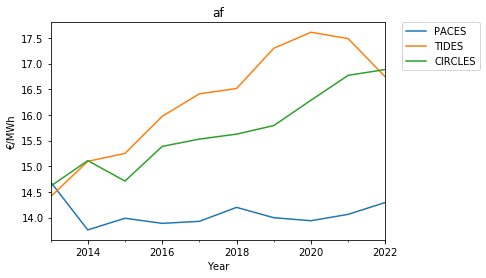

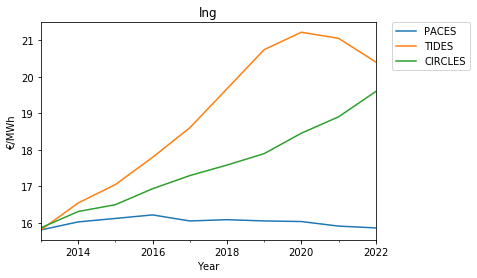

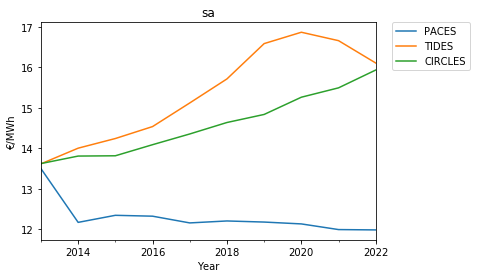

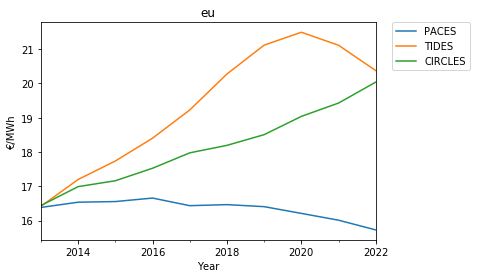

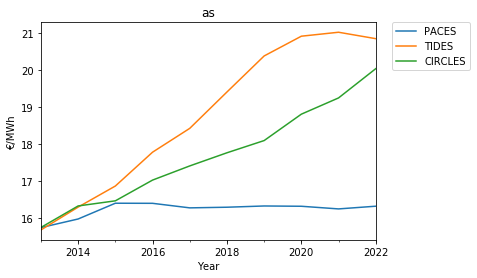

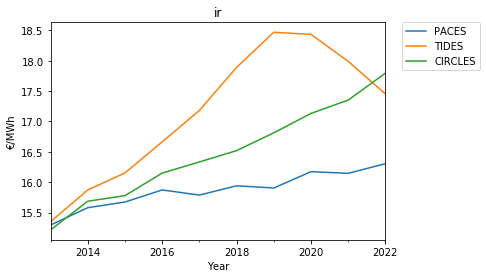

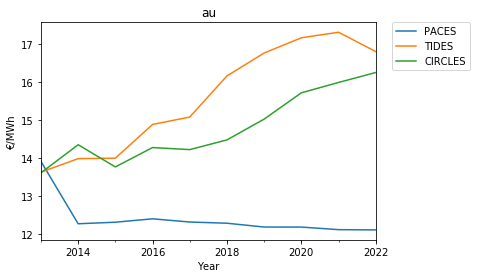

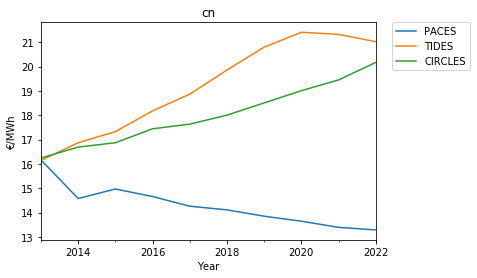

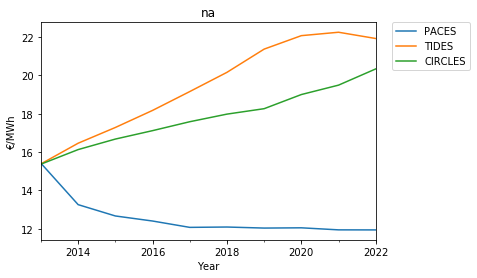

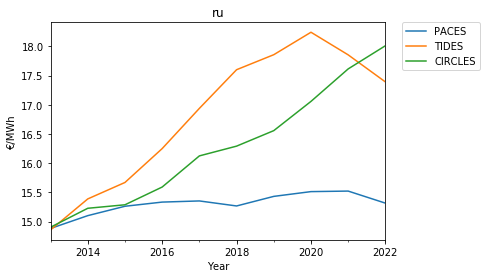

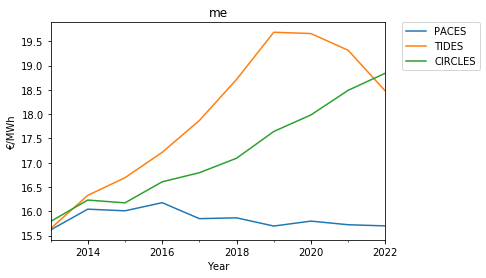

In [13]:
plt.subplots()
for market in init_market:
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df = run_df[run_df[3]==market]
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df = run_df['price'].resample('A').mean().plot(label=i, title=market)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('€/MWh')
    plt.xlabel('Year')
    plt.show();

### saving data for later
To keep this file as clear as possible and for efficiency we visualize the results in a separate file. To transfer the model run data we use the Json library (and possibly excel).

In [14]:
today = datetime.date.today().strftime('%Y%m%d')
outputexcel = '.\exceloutput\%srun.xlsx' %today
writer = pd.ExcelWriter(outputexcel)

def write_to_excel():
    for i in run_market:
        run_df = pd.DataFrame(run_market[i])
        run_df.set_index(0, inplace=True)
        run_df.index = pd.to_datetime(run_df.index)
        run_df.index.name = 'month'
        run_df.rename(columns={1: 'price', 2: 'quantity'}, inplace=True)
        run_df.to_excel(writer, sheet_name=i)
write_to_excel()


In [15]:
# Writing JSON data
# market data
data = run_market
with open('marketdata.json', 'w') as f:
     json.dump(data, f)

In [16]:
# seller/reserve data
data = run_seller
with open('sellerdata.json', 'w') as f:
     json.dump(data, f)

In [17]:
# buyer data
data = run_buyer
with open('buyerdata.json', 'w') as f:
     json.dump(data, f)

In [18]:
#test_df = pd.DataFrame(run_reserve['CIRCLES']))
#test_dict = test_df.to_dict()
#test_df.to_json('reservedf.json',orient='split')
#test_df2 = pd.read_json('reservedf.json',orient='split')


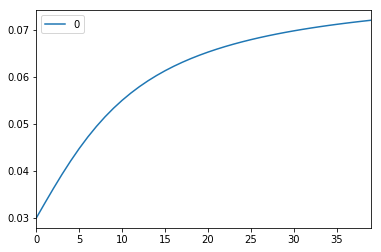

In [19]:
def func_1(x):
    demand = np.arctan(x/10)/(.5*np.pi)*.05+0.03
    return demand

pd.DataFrame([func_1(x) for x in range(40)]).plot()

# References

